In [3]:
import pandas as pd
import numpy as np
import regex as re
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
conda install -c conda-forge hdbscan
import hdbscan

In [4]:
#Importando data set
embargos = pd.read_csv('data/areas_embargadas.csv')

C:\Users\yasmi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Primeiros insights

In [5]:
#1) Existem muitas colunas com muitas células NA
embargos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80647 entries, 0 to 80646
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Nº TAD                     80225 non-null  object 
 1   SERIE TAD                  67496 non-null  object 
 2   Área (ha)                  34022 non-null  object 
 3   Nº A.I.                    67318 non-null  object 
 4   Nome ou Razão Social       72638 non-null  object 
 5   CPF ou CNPJ                71496 non-null  object 
 6   Localização do Imóvel      66584 non-null  object 
 7   UF Infração                76690 non-null  object 
 8   Município Infração         76690 non-null  object 
 9   Município Infrator         76526 non-null  object 
 10  Bairro                     68975 non-null  object 
 11  Endereço                   70888 non-null  object 
 12  Julgamento                 80647 non-null  object 
 13  Infração                   67278 non-null  obj

In [6]:
#Avaliando a porcentagem de NAs por coluna
embargos.isna().sum()

Nº TAD                         422
SERIE TAD                    13151
Área (ha)                    46625
Nº A.I.                      13329
Nome ou Razão Social          8009
CPF ou CNPJ                   9151
Localização do Imóvel        14063
UF Infração                   3957
Município Infração            3957
Município Infrator            4121
Bairro                       11672
Endereço                      9759
Julgamento                       0
Infração                     13369
Data de Inserção na Lista     3960
Código UF                     3957
Código Município              3957
Código Bioma                 35548
Propriedade                  71878
Desmatamento                  4971
CPF/CNPJ                      9151
Status                       13947
Data alteração                8928
Latitude                     13968
Longitude                    14209
Operação                     71091
GEO                          17574
Bioma                        35548
dtype: int64

In [7]:
#Avaliando a quantidade de biomas descritos no dataset
embargos['Bioma'].unique()

array(['Amazonia', 'Costeiro e Marinho', 'Cerrado', 'Mata Atlantica',
       'Caatinga', 'Pampa', 'Pantanal', nan, 'Cerrado,Cerrado',
       'Costeiro e Marinho,Mata Atlantica', 'Cerrado,Pampa',
       'Amazonia,Amazonia', 'Amazonia,Cerrado', 'Amazonia,Mata Atlantica',
       'Cerrado,Mata Atlantica', 'Caatinga,Cerrado',
       'Caatinga,Costeiro e Marinho', 'Amazonia,Costeiro e Marinho',
       'Amazonia,Costeiro e Marinho,Mata Atlantica',
       'Amazonia,Caatinga,Costeiro e Marinho', 'Caatinga,Mata Atlantica',
       'Cerrado,Costeiro e Marinho',
       'Amazonia,Caatinga,Cerrado,Costeiro e Marinho,Mata Atlantica,Pampa,Pantanal',
       'Mata Atlantica,Mata Atlantica', 'Mata Atlantica,Pampa',
       'Pampa,Pampa',
       'Mata Atlantica,Mata Atlantica,Mata Atlantica,Mata Atlantica',
       'Pampa,Pampa,Pampa', 'Pampa,Pampa,Pampa,Pampa',
       'Pampa,Pampa,Pampa,Pampa,Pampa',
       'Mata Atlantica,Mata Atlantica,Mata Atlantica',
       'Caatinga,Cerrado,Costeiro e Marinho', 'Caatin

### Tratando NAs

#### Tratano NAs das colunas que serão usadas para filtrar os dados, de acordo com o objetivo do projeto
1) Apenas desmatamento

2) Apenas do bioma amazônia

3) Tratar NAs das colunas de localização (lat e long)

In [8]:
#As únicas colunas com informações sobre o tipo de infração 'desmatamento' são: 'Infração' e 'Desmatamento'
#Avaliar se é possível substituir os NAs de uma com a outra
embargos[['Infração','Desmatamento']][embargos['Infração'].isna()].isna().sum()

Infração        13369
Desmatamento       37
dtype: int64

In [9]:
#Há 37 linhas que não será possível tratar NAs na info 'Desmatamento'
embargos[['Infração','Desmatamento']][(embargos['Desmatamento'].isna())&(embargos['Infração'].isna())].isna().sum()

Infração        37
Desmatamento    37
dtype: int64

In [10]:
#Dentre as 37 linhas NAN, há 29 casos dentro do bioma de interesse (AM)
embargos[['Infração','Desmatamento','Bioma']][(embargos['Desmatamento'].isna())&(embargos['Infração'].isna())&(embargos['Bioma'] == "Amazonia")].shape[0]

29

In [11]:
#Padrão regex
pattern_desmata = r'[Dd][e][s][m][a]'
#Criação da coluna 'Desmata_cat', construída com a junção das colunas 'Desmatamento' e 'Infração', com objetivo de anular incoerência nos dados
mask_embargo_desmata = (embargos['Desmatamento'] == 'D') | (embargos['Infração'].map(lambda x: len(re.findall(pattern_desmata,str(x))) > 0))
embargos['Desmata_cat'] = mask_embargo_desmata


In [14]:
#Criando coluna 'Desmata_infra' para avaliar se há incoerências entre as colunas 'Infração' e 'Desmatamento'.
embargos['Desmata_infra'] = embargos['Infração'].map(lambda x: len(re.findall(pattern_desmata,str(x))) > 0)
embargos[(embargos['Desmata_infra'] == 0)&(embargos['Desmatamento'] == 1)]

,Nº TAD,SERIE TAD,Área (ha),Nº A.I.,Nome ou Razão Social,CPF ou CNPJ,Localização do Imóvel,UF Infração,Município Infração,Município Infrator,...,CPF/CNPJ,Status,Data alteração,Latitude,Longitude,Operação,GEO,Bioma,Desmata_cat,Desmata_infra


In [16]:
#Avaliar a descrição da 'infração' se há algum outro padrão string não considerada pelo filtro
#Madeira parece ser uma palavra chave para desmatamento
embargos[['Infração','Desmatamento','Desmata_cat']][embargos['Desmata_cat'] == False]['Infração'].unique()

array(['FICA EMBARGADO A ATIVIDADE DE TRANSPORTE DE CARGAS PERIGOSA DE UMA MELOSA, ATÉ SUA REGULARIZAÇÃO NO ÓRGÃO AMBIENTAL COMPETENTE',
       'Fica embargada toda e qualquer atividade no empreendimento autuado, restringindo-se ao local onde efetivamente ocorreu a infração. O embargo tem por objetivo cessar o dano ambiental. ',
       'Ficam embargadas as atividades da empresa em razão da mesma ter adquirido 1.416,282 metros cúbicos de madeiras, sem de fato ter carregado madeiras ficando configurado o cometimento de infração ambiental e o uso de créditos para acobertar madeiras de origem ilegal \n',
       ...,
       'Transportar produto florestal com ATPF rasurada, com emendas, campo em branco ou campo preenchidos em desacordo com o produto ou com a nota fiscal.',
       'Funcionar sem inscrição no Cadastro Técnico Federal. Beneficiamento de minério de alumínio.',
       'Infração de Biopirataria(Não Classificada-Móvel)'], dtype=object)

In [17]:
tb_desmata = embargos[embargos['Desmata_cat'] == True]

### Esse bloco não foi usado no projeto final. Muitas infrações não relacionadas com desmatamento, possuem a palavra chame 'Madeira'

In [18]:
'''pattern_madeira = r'[m][a][d][e][i][r][a][s*][[ de origem ilegal]|[ extraídas ilegalmente]|[ explorada ilegal]|[ exporada fora da área autorizada]|[ oriunda de floresta]|[ sem origem legal]|[sem origem comprovada]]' '''

"pattern_madeira = r'[m][a][d][e][i][r][a][s*][[ de origem ilegal]|[ extraídas ilegalmente]|[ explorada ilegal]|[ exporada fora da área autorizada]|[ oriunda de floresta]|[ sem origem legal]|[sem origem comprovada]]' "

In [19]:
'''embargos[embargos['Infração'].map(lambda x: len(re.findall(pattern_madeira,str(x))) > 0)]['Infração'].unique()'''

"embargos[embargos['Infração'].map(lambda x: len(re.findall(pattern_madeira,str(x))) > 0)]['Infração'].unique()"

In [20]:
#A partir desta análise, foram selecionados os seguintes padrões:
'''
madeiras nativas em toras extraídas ilegalmente #ok
madeiras nativas sem origem comprovada

madeira[s ] de origem ilegal #ok
madeira explorada ilegalmente #ok
madeiras sem origem comprovada #ok
madeiras sem origem legal #ok
madeira oriunda de floresta #ok

exploração ilegal de madeiras
exploração seletiva ilegal de madeira
explorada fora da área autorizada #ok

comprovação de origem de madeiras legais

corte seletivo de madeira
extração ilegal de madeira'''

'''pattern_madeira = r'[Mm][a][d][e][i][r]'

embargos[embargos['Infração'].map(lambda x: len(re.findall(pattern_madeira,str(x))) > 0)]['Infração'].unique()'''

"pattern_madeira = r'[Mm][a][d][e][i][r]'\n\nembargos[embargos['Infração'].map(lambda x: len(re.findall(pattern_madeira,str(x))) > 0)]['Infração'].unique()"

#### Tratando NAs da coluna bioma

In [21]:
tb_desmata.isna().sum()/tb_desmata.shape[0]

Nº TAD                       0.000000
SERIE TAD                    0.087557
Área (ha)                    0.271785
Nº A.I.                      0.000000
Nome ou Razão Social         0.005209
CPF ou CNPJ                  0.006250
Localização do Imóvel        0.132194
UF Infração                  0.000000
Município Infração           0.000000
Município Infrator           0.001094
Bairro                       0.031772
Endereço                     0.015574
Julgamento                   0.000000
Infração                     0.000000
Data de Inserção na Lista    0.000000
Código UF                    0.000000
Código Município             0.000000
Código Bioma                 0.436585
Propriedade                  0.778530
Desmatamento                 0.029949
CPF/CNPJ                     0.006250
Status                       0.003906
Data alteração               0.029949
Latitude                     0.140424
Longitude                    0.143341
Operação                     0.741289
GEO         

In [22]:
#Há necessidade de preencher 8.382 valores NAN da coluna 'Bioma'
tb_desmata['Bioma'].isna().sum()

8382

In [23]:
#A coluna 'UF Infração' poderá ser utilizada filtrar a tabela e diminuir os valores NAN
lista = ['UF Infração','Código UF','Código Bioma','Latitude','Longitude','Bioma']
tb_desmata[lista][tb_desmata['Bioma'].isna()].isna().sum()

UF Infração        0
Código UF          0
Código Bioma    8382
Latitude        1801
Longitude       1857
Bioma           8382
dtype: int64

In [24]:
#Há estados que não pertencem ao bioma 'Amazonia'
tb_desmata['UF Infração'].unique()

array(['PA', 'MT', 'AM', 'RO', 'BA', 'GO', 'CE', 'MS', 'MA', 'AC', 'SE',
       'MG', 'ES', 'TO', 'PE', 'PB', 'RJ', 'SC', 'PI', 'RR', 'RS', 'AL',
       'AP', 'PR', 'RN', 'SP', 'DF'], dtype=object)

In [25]:
#Criando coluna booleana para filtrar a tabela, contendo apenas os estados do bioma 'Amazonia'
lista_inAM = ['PA', 'MT', 'AM', 'RO','MA', 'AC','TO','RR','AP']
tb_desmata['UF_AM'] = tb_desmata['UF Infração'].map(lambda x: 1 if x in lista_inAM else 0)

C:\Users\yasmi\AppData\Local\Temp/ipykernel_7000/1170544252.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tb_desmata['UF_AM'] = tb_desmata['UF Infração'].map(lambda x: 1 if x in lista_inAM else 0)


In [26]:
#Filtrando estados do bioma 'Amazonia'
tb_desmata = tb_desmata[tb_desmata['UF_AM'] == 1]

In [27]:
tb_desmata[tb_desmata['Bioma'].isna()].groupby('UF Infração').count()

,Nº TAD,SERIE TAD,Área (ha),Nº A.I.,Nome ou Razão Social,CPF ou CNPJ,Localização do Imóvel,Município Infração,Município Infrator,Bairro,...,Status,Data alteração,Latitude,Longitude,Operação,GEO,Bioma,Desmata_cat,Desmata_infra,UF_AM
UF Infração,,,,,,,,,,,,,,,,,,,,,
AC,130,43,81,130,120,120,79,130,130,119,...,129,130,120,120,0,119,0,130,130,130
AM,438,436,414,438,431,431,398,438,438,430,...,438,438,412,412,2,403,0,438,438,438
AP,58,58,54,58,57,57,56,58,58,57,...,55,58,55,55,0,55,0,58,58,58
MA,279,274,153,279,259,258,156,279,279,255,...,276,279,157,156,5,118,0,279,279,279
MT,574,528,429,574,568,568,492,574,574,567,...,574,574,558,558,5,513,0,574,574,574
PA,786,742,553,786,769,766,700,786,786,756,...,782,786,699,696,64,675,0,786,786,786
RO,1057,1037,980,1057,1056,1056,900,1057,1057,1040,...,1053,1057,1017,1013,2,1000,0,1057,1057,1057
RR,226,199,166,226,226,226,199,226,226,226,...,224,226,216,215,0,212,0,226,226,226
TO,411,378,350,411,398,398,341,411,411,395,...,411,411,348,344,28,318,0,411,411,411


In [28]:
#Ainda restam 3.959 valores NAN, porém apenas cerca de 1200 possuem incerteza (estados MA, TO, MT)
tb_desmata['Bioma'].isna().sum()

3959

In [29]:
# Criando função para extrair 'Amazonia' da coluna 'Bioma'
def clean_bioma(x):
    pattern_amazon = r'[A][m][a][z][o][n][i][a]'
    lista = re.findall(pattern_amazon, str(x))
    if len(lista) > 0:
        return lista.pop(0)
    else:
        return 'Other'

In [30]:
#Criando coluna 'Bioma_amazon', a qual classifica o bioma como 'Amazonia' ou 'Other'
tb_desmata['Bioma_amazon'] = tb_desmata['Bioma'].map(clean_bioma)

#Agregado tabela pelo código do municipio e bioma
tb_amazon = tb_desmata.groupby(['Código Município','Bioma_amazon']).median().drop(['Código UF', 'CPF/CNPJ', 'Operação', 'GEO',
       'Desmata_cat'], axis = 1)

#Transformando tb_amazon em dicionário
tb_amazon = tb_amazon.reset_index()
tb_amazon = tb_amazon.loc[~tb_amazon['Código Município'].duplicated(),]
tb_amazon.index = tb_amazon['Código Município']
tb_amazon = tb_amazon.drop('Código Município', axis = 1)
dict_amazon = tb_amazon.to_dict()["Bioma_amazon"]

#Atualizando coluna 'Bioma_amazon', a partir do dicionário criado, a fim de tratar os NAs
tb_desmata['Bioma_amazon'] = tb_desmata['Código Município'].map(dict_amazon)

In [31]:
tb_desmata[['Bioma','Bioma_amazon']][(tb_desmata['Bioma'].isna())&(tb_desmata['Bioma_amazon'] == 'Amazonia')]

,Bioma,Bioma_amazon
5984,NaN,Amazonia
6038,NaN,Amazonia
6790,NaN,Amazonia
6805,NaN,Amazonia
6806,NaN,Amazonia
...,...,...
80461,NaN,Amazonia
80486,NaN,Amazonia
80490,NaN,Amazonia
80528,NaN,Amazonia


In [32]:
#Os NAs da info BIOMA foram tratados com sucesso
tb_desmata['Bioma_amazon'].isna().sum()

0

In [33]:
#Dropando biomas que não são 'Amazonia'
tb_desmata = tb_desmata[tb_desmata['Bioma_amazon'] == 'Amazonia']

In [34]:
tb_desmata.shape

(11300, 32)

#### Tratando NAs das colunas de localização (lat e long)

In [35]:
#É possível preencher a latitude e longitude com o município
tb_desmata[['UF Infração','Código Município','Município Infração','Bioma','Latitude','Longitude']][tb_desmata['Latitude'].isna()].isna().sum()

UF Infração             0
Código Município        0
Município Infração      0
Bioma                 205
Latitude              717
Longitude             714
dtype: int64

In [36]:
#O código do município, é referente ao município de infração
embargos[['Código Município','Município Infração','Município Infrator']][embargos['Município Infração'] == 'Novo Repartimento']

,Código Município,Município Infração,Município Infrator
0,1505064.0,Novo Repartimento,moju/PA
1659,1505064.0,Novo Repartimento,Novo Repartimento/PA
2129,1505064.0,Novo Repartimento,Canaã dos Carajás/PA
2155,1505064.0,Novo Repartimento,Araguaína/TO
4045,1505064.0,Novo Repartimento,Araguaína/TO
...,...,...,...
79380,1505064.0,Novo Repartimento,Novo Repartimento/PA
79865,1505064.0,Novo Repartimento,Novo Repartimento/PA
79941,1505064.0,Novo Repartimento,Novo Repartimento/PA
79990,1505064.0,Novo Repartimento,Novo Repartimento/PA


In [37]:
#O python está entendendo as coordenadas como string
tb_desmata[['Latitude','Longitude']].describe()

,Latitude,Longitude
count,10583,10574
unique,9251,9599
top,0,0
freq,197,201


In [38]:
#Criando função para Transformar as coordenadas em colunas numéricas
def convert(x):
    if x is not np.nan:
        x = float(x.replace(',','.'))
        if x == float(0):
            return np.nan
        else:
            return x
    else:
        return np.nan

In [39]:
#Transformar as coordenadas em colunas numéricas
tb_desmata['Latitude'] = tb_desmata['Latitude'].map(convert)
tb_desmata['Longitude'] = tb_desmata['Longitude'].map(convert)

In [40]:
# Não há necessidade de dropar linhas das coordenadas
tb_desmata[['Latitude','Longitude']].describe()

,Latitude,Longitude
count,10386.000000,10373.000000
mean,-8.187176,-59.417166
std,3.899317,6.494314
min,-75.999333,-90.434444
25%,-10.266736,-64.583333
50%,-9.268889,-59.805833
75%,-6.536458,-54.309722
max,10.419972,-5.759139


In [41]:
#Criando tabela de coordenadas por cidade.
tb_coord = tb_desmata[['Código Município','Município Infração','UF Infração','Latitude','Longitude']].groupby(['Código Município','Município Infração','UF Infração']).median()

In [42]:
#Deixar apenas as cidades que não possuem coordenadas.
tb_coord_na = tb_coord[tb_coord.isna()]

In [43]:
#Excluir duplicatas
tb_coord_na = tb_coord[tb_coord.duplicated()]

In [44]:
#Transformar índices em colunas
tb_coord_na = tb_coord_na.reset_index()

In [45]:
#Importar dataset que contem as coordenadas faltantes
coord_cidades = pd.read_csv('data/BRAZIL_CITIES_REV2022.csv')

In [46]:
#Avaliar colunas
coord_cidades.columns

Index(['CITY', 'STATE', 'CAPITAL', 'IBGE_RES_POP', 'IBGE_RES_POP_BRAS',
       'IBGE_RES_POP_ESTR', 'IBGE_DU', 'IBGE_DU_URBAN', 'IBGE_DU_RURAL',
       'IBGE_POP', 'IBGE_1', 'IBGE_1-4', 'IBGE_5-9', 'IBGE_10-14',
       'IBGE_15-59', 'IBGE_60+', 'IBGE_PLANTED_AREA', 'IBGE_CROP_PRODUCTION_$',
       'IDHM Ranking 2010', 'IDHM', 'IDHM_Renda', 'IDHM_Longevidade',
       'IDHM_Educacao', 'LONG', 'LAT', 'ALT', 'PAY_TV', 'FIXED_PHONES', 'AREA',
       'REGIAO_TUR', 'CATEGORIA_TUR', 'ESTIMATED_POP', 'RURAL_URBAN',
       'GVA_AGROPEC', 'GVA_INDUSTRY', 'GVA_SERVICES', 'GVA_PUBLIC',
       'GVA_TOTAL', 'TAXES', 'GDP', 'POP_GDP', 'GDP_CAPITA', 'GVA_MAIN',
       'MUN_EXPENDIT', 'COMP_TOT', 'COMP_A', 'COMP_B', 'COMP_C', 'COMP_D',
       'COMP_E', 'COMP_F', 'COMP_G', 'COMP_H', 'COMP_I', 'COMP_J', 'COMP_K',
       'COMP_L', 'COMP_M', 'COMP_N', 'COMP_O', 'COMP_P', 'COMP_Q', 'COMP_R',
       'COMP_S', 'COMP_T', 'COMP_U', 'HOTELS', 'BEDS', 'Pr_Agencies',
       'Pu_Agencies', 'Pr_Bank', 'Pu_Bank', 'Pr_

In [47]:
#A máxima long do Brasil é -34
coord_cidades[['LAT','LONG']].describe()

,LAT,LONG
count,5578.000000,5578.000000
mean,-16.412927,-46.122937
std,8.307731,6.776943
min,-33.687600,-72.916500
25%,-22.835700,-50.848350
50%,-18.071300,-46.482350
75%,-8.458575,-41.363800
max,4.585400,0.000000


In [48]:
coord_cidades = coord_cidades[coord_cidades['LONG']< -34]

In [49]:
#Criar dicionários lat e long para substituir os NAs da tabela de coordenadas vazias (tb_coord_na)
tb_coord = coord_cidades[['CITY','LONG','LAT']]
tb_coord.index = tb_coord['CITY']

dict_lat = tb_coord.to_dict()['LAT']
dict_long = tb_coord.to_dict()['LONG']

In [50]:
#Substituir lat e long vazias da tabela "tb_coord_na" a partir do dataset "coord_cidades"
tb_coord_na['Latitude'] = tb_coord_na['Município Infração'].map(dict_lat)
tb_coord_na['Longitude'] = tb_coord_na['Município Infração'].map(dict_long)

In [51]:
#Avaliar se ainda restam NAs na tabela
tb_coord_na[tb_coord_na['Latitude'].isna()]

,Código Município,Município Infração,UF Infração,Latitude,Longitude
3,2106755.0,Miranda do Norte,MA,NaN,NaN
4,2108256.0,Pedro do Rosário,MA,NaN,NaN
7,2111706.0,São Vicente Ferrer,MA,NaN,NaN


In [52]:
#Parece que a diferenciação de maiúsculas e minúsculas causou a remanescência de alguns NAs
coord_cidades[coord_cidades['CITY'] == "Pedro Do Rosário"]

,CITY,STATE,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,...,Pu_Bank,Pr_Assets,Pu_Assets,Cars,Motorcycles,Wheeled_tractor,UBER,MAC,WAL-MART,POST_OFFICES
3683,Pedro Do Rosário,MA,0,22732,22732,0,5336,1374,3962,5877,...,0,0,0,170,1784,0,0,0,0,1


In [53]:
#Repetindo o processo acima, porém com a coluna (nova) de cidades com letras minúsculas
coord_cidades['CITY_lower'] = coord_cidades['CITY'].map(lambda x: x.lower())
tb_coord = coord_cidades[['CITY_lower','LONG','LAT']]
tb_coord.index = tb_coord['CITY_lower']

dict_lat = tb_coord.to_dict()['LAT']
dict_long = tb_coord.to_dict()['LONG']

tb_coord_na['Município_lower'] = tb_coord_na['Município Infração'].map(lambda x: x.lower())
tb_coord_na['Latitude'] = tb_coord_na['Município_lower'].map(dict_lat)
tb_coord_na['Longitude'] = tb_coord_na['Município_lower'].map(dict_long)

In [54]:
#Verificando NAs remascentens
tb_coord_na[tb_coord_na['Latitude'].isna()]

,Código Município,Município Infração,UF Infração,Latitude,Longitude,Município_lower
7,2111706.0,São Vicente Ferrer,MA,NaN,NaN,são vicente ferrer


In [55]:
#Substituindo o NA remanescente
dict_lat["são vicente ferrer"] = coord_cidades[coord_cidades['STATE'] == "MA"]['LAT'].median()

dict_long["são vicente ferrer"] = coord_cidades[coord_cidades['STATE'] == "MA"]['LONG'].median()

tb_coord_na['Latitude'] = tb_coord_na['Município_lower'].map(dict_lat)
tb_coord_na['Longitude'] = tb_coord_na['Município_lower'].map(dict_long)

In [56]:
#Os NAs das colunas de coordenadas foram substituidos com sucesso na tabela "tb_coord_na"
tb_coord_na[tb_coord_na['Latitude'].isna()]

,Código Município,Município Infração,UF Infração,Latitude,Longitude,Município_lower


In [57]:
tb_coord_na.columns

Index(['Código Município', 'Município Infração', 'UF Infração', 'Latitude',
       'Longitude', 'Município_lower'],
      dtype='object')

In [58]:
# Transformando da "tb_coord_na" em dicionario
tb_coord_na.index = tb_coord_na['Código Município']
tb_coord_na_todict = tb_coord_na.drop(['Município Infração','UF Infração','Município_lower'], axis = 1)

dict_lat_final = tb_coord_na_todict.to_dict()['Latitude']
dict_long_final = tb_coord_na_todict.to_dict()['Longitude']

tb_desmata['Latitude_imp'] = tb_desmata['Código Município'].map(lambda x: dict_lat_final if type(x) is np.nan else x)
tb_desmata['Longitude_imp'] = tb_desmata['Código Município'].map(lambda x: dict_long_final if type(x) is np.nan else x)

In [59]:
#Colunas de coordenadas não possuem mais NAs
tb_desmata['Latitude_imp'].isna().sum()

0

In [60]:
tb_desmata['Data de Inserção na Lista'].isna().sum()

0

In [61]:
#Convertendo a coluna 'Data de Inserção na Lista' para o tipo datetime
tb_desmata['Data de Inserção na Lista'] = tb_desmata['Data de Inserção na Lista'].map(lambda x:
                                                                                      datetime.date(datetime.strptime(x, '%d/%m/%Y')))

In [62]:
#Criando colunas 'Year','Month' e 'Day'
tb_desmata['Year'] = tb_desmata['Data de Inserção na Lista'].map(lambda x: x.year)
tb_desmata['Month'] = tb_desmata['Data de Inserção na Lista'].map(lambda x: x.month)
tb_desmata['Day'] = tb_desmata['Data de Inserção na Lista'].map(lambda x: x.day)

In [63]:
#Criando tabela limpa
tb_desmata_clean = tb_desmata[['CPF ou CNPJ','Município Infração','UF Infração','Data de Inserção na Lista','Latitude','Longitude','Year','Month','Day']]

In [64]:
#A tabela limpa não possui nenhum NA
tb_desmata_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11300 entries, 0 to 80638
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CPF ou CNPJ                11237 non-null  object 
 1   Município Infração         11300 non-null  object 
 2   UF Infração                11300 non-null  object 
 3   Data de Inserção na Lista  11300 non-null  object 
 4   Latitude                   10386 non-null  float64
 5   Longitude                  10373 non-null  float64
 6   Latitude_imp               11300 non-null  float64
 7   Longitude_imp              11300 non-null  float64
 8   Year                       11300 non-null  int64  
 9   Month                      11300 non-null  int64  
 10  Day                        11300 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 1.0+ MB


In [65]:
tb_desmata_clean.columns

Index(['CPF ou CNPJ', 'Município Infração', 'UF Infração',
       'Data de Inserção na Lista', 'Latitude', 'Longitude', 'Latitude_imp',
       'Longitude_imp', 'Year', 'Month', 'Day'],
      dtype='object')

In [66]:
tb_desmata_clean.groupby('UF Infração')['Year'].count().sort_values()

UF Infração
TO       3
AP     112
MA     256
RR     500
AM    1020
AC    1363
MT    2238
RO    2734
PA    3074
Name: Year, dtype: int64

In [67]:
tb_desmata_clean.describe()

,Latitude,Longitude,Latitude_imp,Longitude_imp,Year,Month,Day
count,10386.000000,10373.000000,1.130000e+04,1.130000e+04,11300.000000,11300.000000,11300.000000
mean,-8.187176,-59.417166,2.074863e+06,2.074863e+06,2011.530885,6.987080,16.095487
std,3.899317,6.494314,1.518413e+06,1.518413e+06,3.918321,3.379526,8.678227
min,-75.999333,-90.434444,1.100015e+06,1.100015e+06,2005.000000,1.000000,1.000000
25%,-10.266736,-64.583333,1.200054e+06,1.200054e+06,2009.000000,4.000000,9.000000
50%,-9.268889,-59.805833,1.500503e+06,1.500503e+06,2011.000000,7.000000,16.000000
75%,-6.536458,-54.309722,1.508050e+06,1.508050e+06,2013.000000,10.000000,24.000000
max,10.419972,-5.759139,5.108907e+06,5.108907e+06,2022.000000,12.000000,31.000000


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

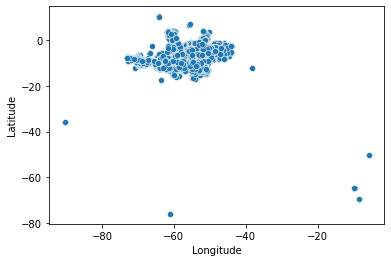

In [68]:
sns.scatterplot(data = tb_desmata_clean, x = 'Longitude', y = 'Latitude')

<AxesSubplot:xlabel='Year', ylabel='Count'>

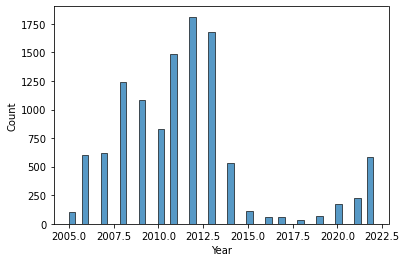

In [70]:
sns.histplot(data=tb_desmata_clean, x="Year")

In [71]:
tb_desmata_clean = tb_desmata_clean[(tb_desmata_clean['Longitude'].notna()) & (tb_desmata_clean['Latitude'].notna())]

In [72]:
tb_desmata_clean = tb_desmata_clean[(tb_desmata_clean['Latitude'] < 6) & (tb_desmata_clean['Latitude'] > -15)]
tb_desmata_clean = tb_desmata_clean[(tb_desmata_clean['Longitude'] < -41) & (tb_desmata_clean['Longitude'] > -75)]

In [73]:
tb_desmata_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10331 entries, 5984 to 80638
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CPF ou CNPJ                10315 non-null  object 
 1   Município Infração         10331 non-null  object 
 2   UF Infração                10331 non-null  object 
 3   Data de Inserção na Lista  10331 non-null  object 
 4   Latitude                   10331 non-null  float64
 5   Longitude                  10331 non-null  float64
 6   Latitude_imp               10331 non-null  float64
 7   Longitude_imp              10331 non-null  float64
 8   Year                       10331 non-null  int64  
 9   Month                      10331 non-null  int64  
 10  Day                        10331 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 968.5+ KB


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

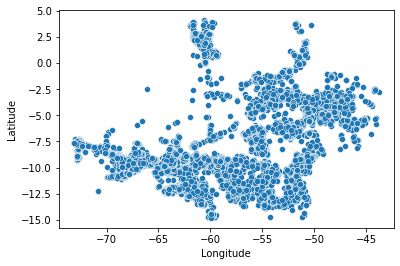

In [74]:
sns.scatterplot(data = tb_desmata_clean, x = 'Longitude', y = 'Latitude')

In [75]:
kmeans_fit = KMeans()
kmeans_fit.fit(tb_desmata_clean[['Longitude', 'Latitude']])
tb_desmata_clean['pred_cluster'] = kmeans_fit.predict(tb_desmata_clean[['Longitude', 'Latitude']])
tb_desmata_clean['pred_cluster'] = kmeans_fit.labels_
kmeans_fit.cluster_centers_

array([[-63.74300677, -10.02432546],
       [-54.91469804,  -6.85685226],
       [-60.60273172,   1.55745601],
       [-49.31783715,  -4.42106538],
       [-68.69101453,  -9.16480464],
       [-59.12244267, -10.9063163 ],
       [-52.77947905, -11.30168681],
       [-53.74747167,  -2.43756548]])

In [76]:
centroids = pd.DataFrame(kmeans_fit.cluster_centers_)
centroids.columns = ['Longitude', 'Latitude']

In [127]:
centroids.to_excel('centroids.xls')

C:\Users\yasmi\AppData\Local\Temp/ipykernel_7000/425655253.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  centroids.to_excel('centroids.xls')


[[-63.74300677 -10.02432546]
 [-54.91469804  -6.85685226]
 [-60.60273172   1.55745601]
 [-49.31783715  -4.42106538]
 [-68.69101453  -9.16480464]
 [-59.12244267 -10.9063163 ]
 [-52.77947905 -11.30168681]
 [-53.74747167  -2.43756548]]


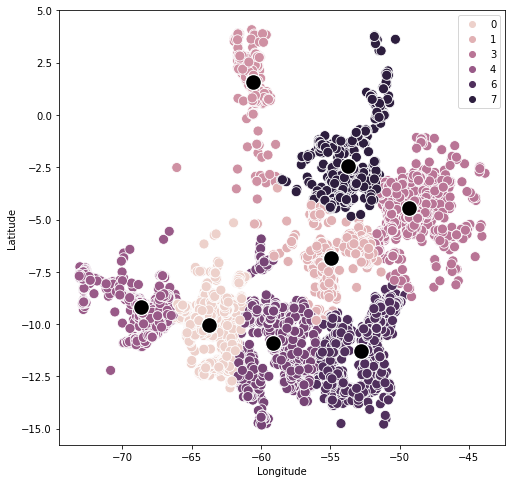

In [77]:
print(kmeans_fit.cluster_centers_)
plt.figure(figsize=(8,8))
sns.scatterplot(data = tb_desmata_clean, x = 'Longitude', y = 'Latitude', hue = 'pred_cluster', s = 100);
sns.scatterplot(data = centroids, x = 'Longitude', y = 'Latitude', color = 'black', s = 250);

In [78]:
tb_desmata_clean[['UF Infração','pred_cluster','Year']].groupby(['UF Infração','pred_cluster']).count()

Year
UF Infração pred_cluster      
AC          0                2
            4             1221
AM          0              184
            1                7
            2               21
            4              587
            5               75
            7               15
AP          7              108
MA          3              159
MT          0               15
            1               17
            2                1
            5             1009
            6             1094
PA          1             1231
            3              768
            5               17
            6              132
            7              616
RO          0             2193
            1                2
            4               37
            5              334
RR          2              484
TO          3                2

In [79]:
inertia_list = []

for i in range(2, 11):
    kmeans_fit = KMeans(n_clusters = i)
    kmeans_fit.fit(tb_desmata_clean[['Longitude', 'Latitude']])
    inertia_list.append(kmeans_fit.inertia_)
    
tb_inertia = pd.DataFrame({'k' : list(range(2, 11)), 'inertia' : inertia_list})
tb_inertia.head(10)

,k,inertia
0,2,229637.335250
1,3,157226.536967
2,4,112707.258666
3,5,76165.840700
4,6,60543.795337
5,7,46099.434922
6,8,39783.149610
7,9,34565.412446
8,10,30937.962937


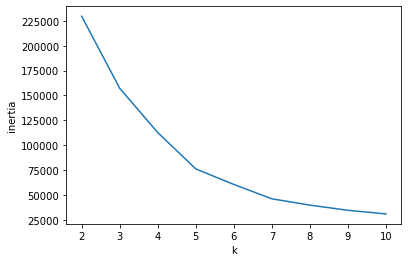

In [80]:
sns.lineplot(data = tb_inertia, x = 'k', y = 'inertia');

In [85]:
tb_desmata_clean['LAT_DEMEAN'] = tb_desmata_clean['Latitude'] - tb_desmata_clean['Latitude'].median()
tb_desmata_clean['LONG_DEMEAN'] = tb_desmata_clean['Longitude'] - tb_desmata_clean['Longitude'].median()
tb_desmata_clean['LONG_UTM'] = tb_desmata_clean['LONG_DEMEAN'] * 113819
tb_desmata_clean['LAT_UTM'] = tb_desmata_clean['LAT_DEMEAN'] * 113819

In [86]:
tb_desmata_clean[['Latitude','Longitude','LAT_DEMEAN','LONG_DEMEAN','LONG_UTM','LAT_UTM']].describe()

,Latitude,Longitude,LAT_DEMEAN,LONG_DEMEAN,LONG_UTM,LAT_UTM
count,10331.000000,10331.000000,10331.000000,10331.000000,1.033100e+04,1.033100e+04
mean,-8.143991,-59.443207,1.120176,0.399293,4.544717e+04,1.274973e+05
std,3.647867,6.414342,3.647867,6.414342,7.300740e+05,4.151966e+05
min,-14.820556,-73.111111,-5.556389,-13.268611,-1.510220e+06,-6.324226e+05
25%,-10.258537,-64.589444,-0.994370,-4.746944,-5.402924e+05,-1.131782e+05
50%,-9.264167,-59.842500,0.000000,0.000000,0.000000e+00,0.000000e+00
75%,-6.535014,-54.307028,2.729153,5.535473,6.300419e+05,3.106295e+05
max,4.082222,-43.831389,13.346389,16.011111,1.822369e+06,1.519073e+06


In [90]:
hdb_fit = hdbscan.HDBSCAN()

In [91]:
hdb_fit.fit(tb_desmata_clean[['LONG_UTM','LAT_UTM']])

HDBSCAN()

In [92]:
tb_desmata_clean['hdb_label_3'] = [str(x) for x in hdb_fit.labels_]

In [93]:
hdb_fit.labels_.max()

464

In [94]:
hdb_fit.probabilities_

array([1.       , 1.       , 0.5438712, ..., 0.       , 0.7607022,
       0.       ])

In [95]:
hdb_precomp_fit = hdbscan.HDBSCAN(min_cluster_size = 10, min_samples = 100)
hdb_precomp_fit.fit(tb_desmata_clean[['LONG_UTM','LAT_UTM']])

HDBSCAN(min_cluster_size=10, min_samples=100)

<AxesSubplot:ylabel='$\\lambda$ value'>

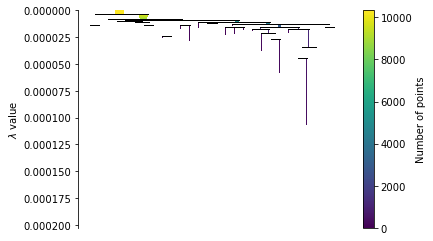

In [96]:
hdb_precomp_fit.condensed_tree_.plot()


In [97]:
hdb_precomp_fit.labels_.max()

25

In [98]:
tb_desmata_clean['hdb_label_4'] = [str(x) for x in hdb_precomp_fit.labels_]

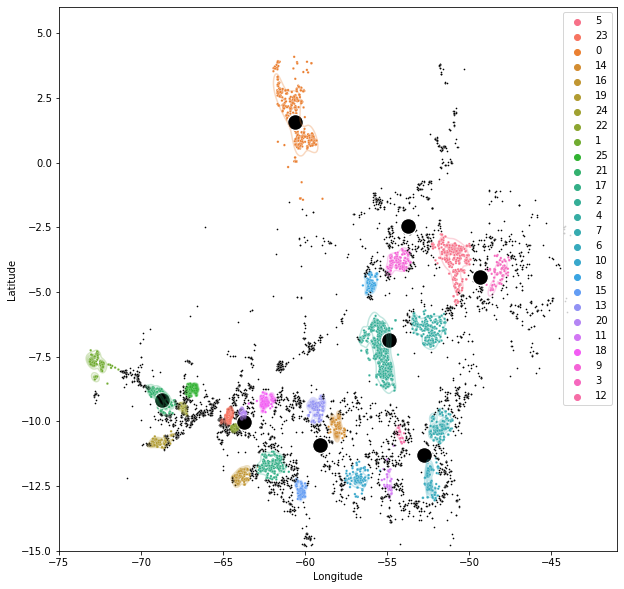

In [99]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] != '-1'], x="Longitude", y="Latitude", 
    hue="hdb_label_4",
    ax = ax, s=6
)
sns.scatterplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '-1'], x="Longitude", y="Latitude", 
    ax = ax, color = 'black', s=3
)
sns.kdeplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] != '-1'], x="Longitude", y="Latitude", 
    hue="hdb_label_4", alpha = 0.3, ax = ax
)
sns.scatterplot(data = centroids, x = 'Longitude', y = 'Latitude', color = 'black', s = 250);

ax.set_ylim(-15, 6)
ax.set_xlim(-75, -41);

<AxesSubplot:xlabel='Year', ylabel='hdb_label_4'>

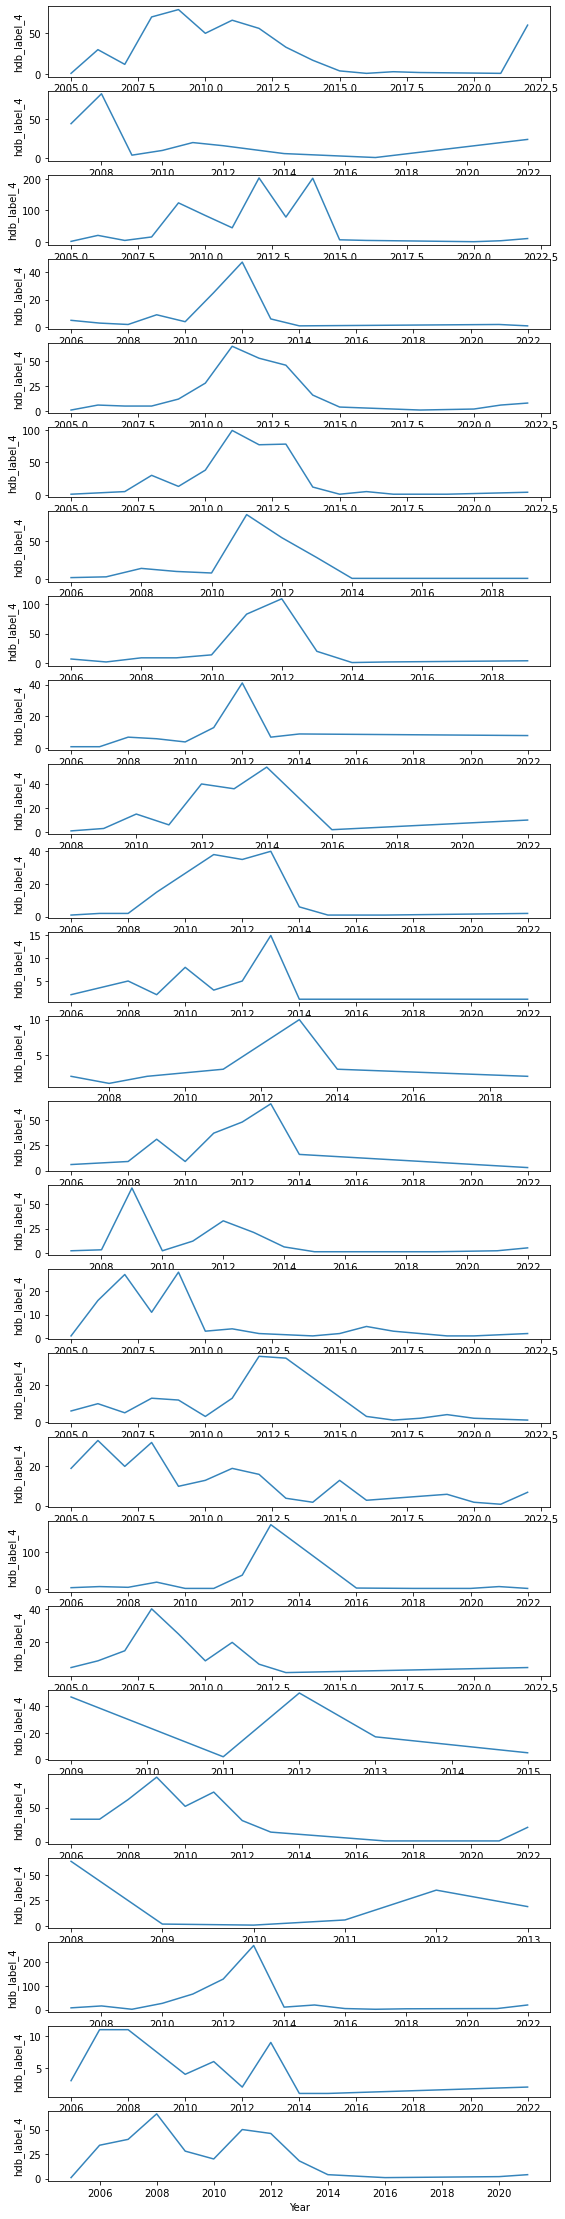

In [100]:
fig, ax = plt.subplots(26, 1, figsize=(9, 40))

sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '0'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[0],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '1'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '2'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[2],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '3'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[3],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '4'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[4],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '5'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[5],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '6'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[6],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '7'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[7],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '8'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[8],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '9'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[9],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '10'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[10],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '11'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[11],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '12'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[12],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '13'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[13],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '14'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[14],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '15'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[15],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '16'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[16],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '17'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[17],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '18'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[18],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '19'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[19],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '20'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[20],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '21'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[21],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '22'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[22],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '23'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[23],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '24'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[24],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '25'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[25],
    alpha=0.9,
)

In [101]:
sns.color_palette("Paired")
colors_discrete = sns.color_palette("Paired")

<AxesSubplot:xlabel='Year', ylabel='hdb_label_4'>

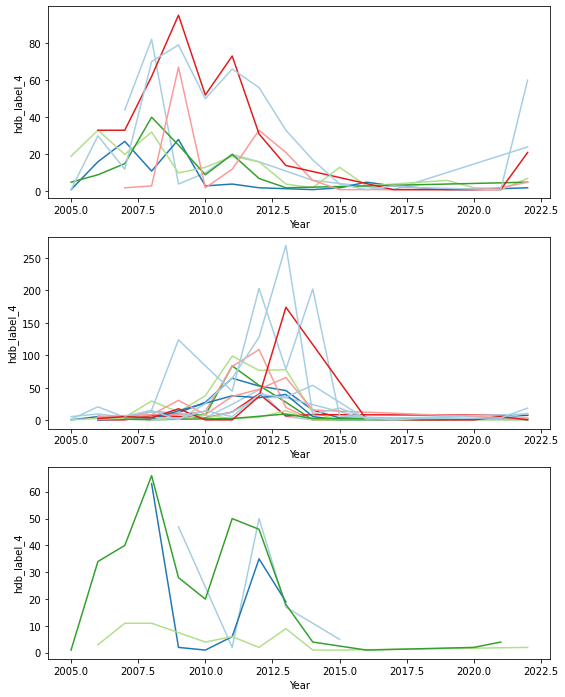

In [102]:
fig, ax = plt.subplots(3, 1, figsize=(9, 12))

#Series temporais com picos em 2008
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] =='1'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[0],
    color = colors_discrete[0]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '15'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[0],
    color = colors_discrete[1]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '17'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[0],
    color = colors_discrete[2]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '19'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[0],
    color = colors_discrete[3]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '14'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[0],
    color = colors_discrete[4]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '21'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[0],
    color = colors_discrete[5]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '0'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[0],
    color = colors_discrete[0]
)
#Series temporais com picos em 2012
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] =='3'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[0]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '4'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[1]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '5'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[2]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '6'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[3]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '7'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[4]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '8'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[5]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '16'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[0]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] =='2'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[0]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '10'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[1]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '11'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[2]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '12'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[3]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '13'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[4]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '18'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[5]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '23'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[0]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '9'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[0]
)

#Series temporais com picos em 2008 e 2012
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] =='20'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[2],
    color = colors_discrete[0]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '22'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[2],
    color = colors_discrete[1]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '24'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[2],
    color = colors_discrete[2]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '25'].groupby('Year')['hdb_label_4'].count().to_frame().reset_index(),
    x="Year",
    y="hdb_label_4",
    ax=ax[2],
    color = colors_discrete[3]
)

In [103]:
mask_2008 = ['1','15','17','19','14','21','0']
mask_2012 = ['3', '4', '5', '6', '7', '8', '16', '2', '10', '11', '12', '13', '18', '23', '9']
mask_ambos = ['20', '22', '24', '25']
tb_desmata_clean['mask_2008'] = tb_desmata_clean['hdb_label_4'].map(lambda x: 1 if x in mask_2008 else 0)
tb_desmata_clean['mask_2012'] = tb_desmata_clean['hdb_label_4'].map(lambda x: 1 if x in mask_2012 else 0)
tb_desmata_clean['mask_ambos'] = tb_desmata_clean['hdb_label_4'].map(lambda x: 1 if x in mask_ambos else 0)

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

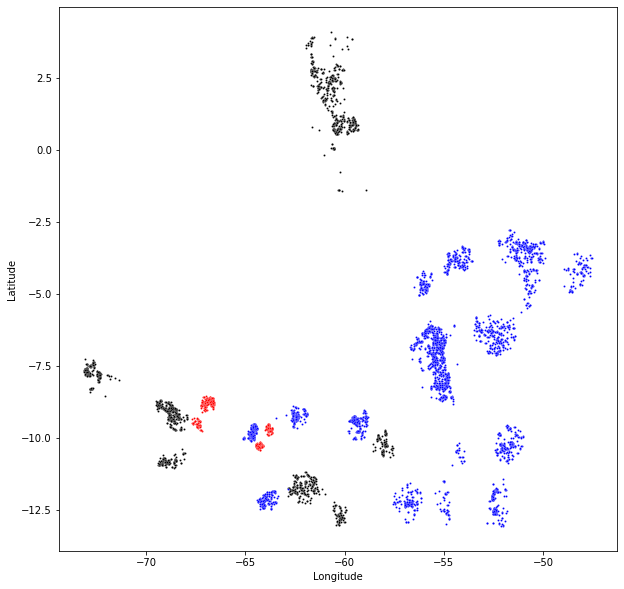

In [104]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(
    data=tb_desmata_clean[tb_desmata_clean['mask_2008'] == 1], x="Longitude", y="Latitude", 
    ax = ax, color = 'black', s=4
)
sns.scatterplot(
    data=tb_desmata_clean[tb_desmata_clean['mask_2012'] == 1], x="Longitude", y="Latitude", 
    ax = ax, color = 'blue', s=4
)
sns.scatterplot(
    data=tb_desmata_clean[tb_desmata_clean['mask_ambos'] == 1], x="Longitude", y="Latitude", 
    ax = ax, color = 'red', s=4
)

In [126]:
tb_desmata_clean.to_excel('tb_desmata_clean.xls')

C:\Users\yasmi\AppData\Local\Temp/ipykernel_7000/2205761067.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  tb_desmata_clean.to_excel('tb_desmata_clean.xls')


<AxesSubplot:xlabel='Month', ylabel='hdb_label_4'>

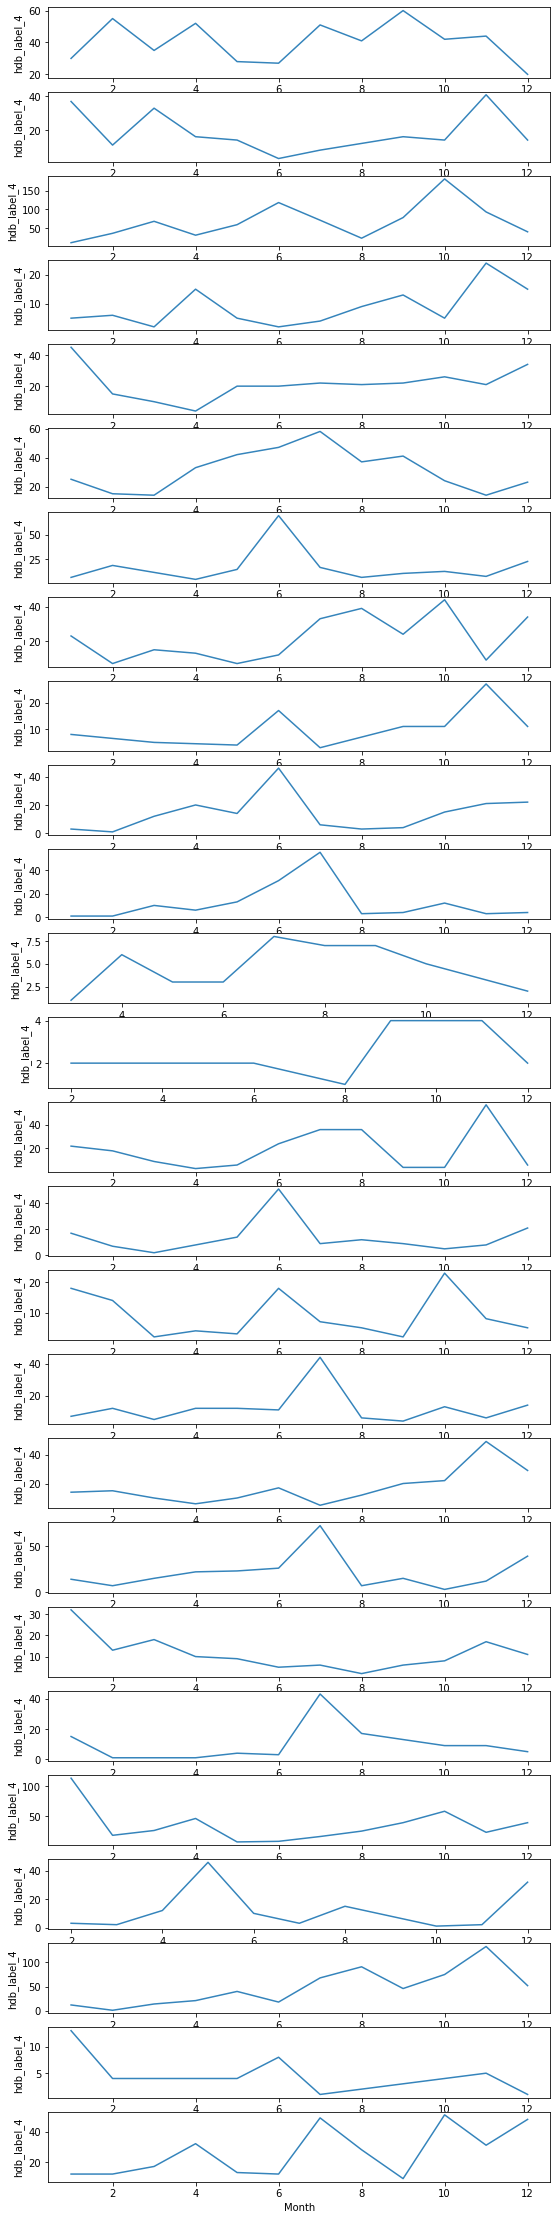

In [106]:
fig, ax = plt.subplots(26, 1, figsize=(9, 40))

sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '0'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[0],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '1'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '2'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[2],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '3'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[3],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '4'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[4],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '5'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[5],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '6'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[6],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '7'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[7],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '8'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[8],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '9'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[9],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '10'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[10],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '11'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[11],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '12'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[12],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '13'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[13],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '14'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[14],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '15'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[15],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '16'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[16],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '17'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[17],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '18'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[18],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '19'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[19],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '20'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[20],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '21'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[21],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '22'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[22],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '23'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[23],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '24'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[24],
    alpha=0.9,
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '25'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[25],
    alpha=0.9,
)

<AxesSubplot:xlabel='Month', ylabel='hdb_label_4'>

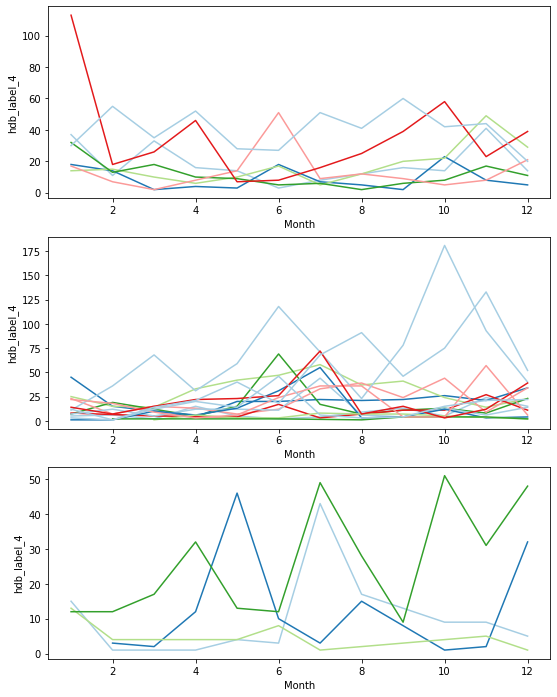

In [107]:
fig, ax = plt.subplots(3, 1, figsize=(9, 12))

#Series temporais com picos em 2008
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] =='1'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[0],
    color = colors_discrete[0]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '15'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[0],
    color = colors_discrete[1]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '17'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[0],
    color = colors_discrete[2]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '19'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[0],
    color = colors_discrete[3]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '14'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[0],
    color = colors_discrete[4]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '21'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[0],
    color = colors_discrete[5]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '0'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[0],
    color = colors_discrete[0]
)
#Series temporais com picos em 2012
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] =='3'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[0]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '4'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[1]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '5'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[2]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '6'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[3]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '7'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[4]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '8'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[5]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '16'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[0]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] =='2'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[0]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '10'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[1]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '11'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[2]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '12'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[3]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '13'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[4]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '18'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[5]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '23'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[0]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '9'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[1],
    color = colors_discrete[0]
)

#Series temporais com picos em 2008 e 2012
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] =='20'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[2],
    color = colors_discrete[0]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '22'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[2],
    color = colors_discrete[1]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '24'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[2],
    color = colors_discrete[2]
)
sns.lineplot(
    data=tb_desmata_clean[tb_desmata_clean['hdb_label_4'] == '25'].groupby('Month')['hdb_label_4'].count().to_frame().reset_index(),
    x="Month",
    y="hdb_label_4",
    ax=ax[2],
    color = colors_discrete[3]
)

In [108]:
tb_bimestre_desmata = tb_desmata_clean.groupby(['hdb_label_4','Month'])['Year'].count().reset_index()
tb_bimestre_desmata['Bimestre'] = tb_bimestre_desmata['Month'].map(lambda x: x/2 if x % 2 == 0 else (x+1)/2)

In [109]:
tb_bimestre_desmata

,hdb_label_4,Month,Year,Bimestre,Nota_corte
0,-1,1,340,1.0,1
1,-1,2,289,1.0,1
2,-1,3,273,2.0,1
3,-1,4,405,2.0,1
4,-1,5,288,3.0,1
...,...,...,...,...,...
305,9,8,3,4.0,0
306,9,9,4,5.0,0
307,9,10,15,5.0,0
308,9,11,21,6.0,0


In [110]:
dict_lat_cluster = tb_desmata_clean.groupby(['hdb_label_4'])['Latitude'].median().to_dict()
dict_long_cluster = tb_desmata_clean.groupby(['hdb_label_4'])['Longitude'].median().to_dict()

In [111]:
len(dict_lat_cluster)

27

In [112]:
tb_bimestre_desmata['Lat_median'] = tb_bimestre_desmata['hdb_label_4'].map(dict_lat_cluster)
tb_bimestre_desmata['Long_median'] = tb_bimestre_desmata['hdb_label_4'].map(dict_long_cluster)

In [113]:
tb_bimestre_desmata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hdb_label_4  310 non-null    object 
 1   Month        310 non-null    int64  
 2   Year         310 non-null    int64  
 3   Bimestre     310 non-null    float64
 4   Nota_corte   310 non-null    int64  
 5   Lat_median   310 non-null    float64
 6   Long_median  310 non-null    float64
dtypes: float64(3), int64(3), object(1)
memory usage: 17.1+ KB


In [125]:
tb_bimestre_desmata.to_excel('tb_bimestre_desmata.xls')

C:\Users\yasmi\AppData\Local\Temp/ipykernel_7000/392675430.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  tb_bimestre_desmata.to_excel('tb_bimestre_desmata.xls')


<AxesSubplot:xlabel='Long_median', ylabel='Lat_median'>

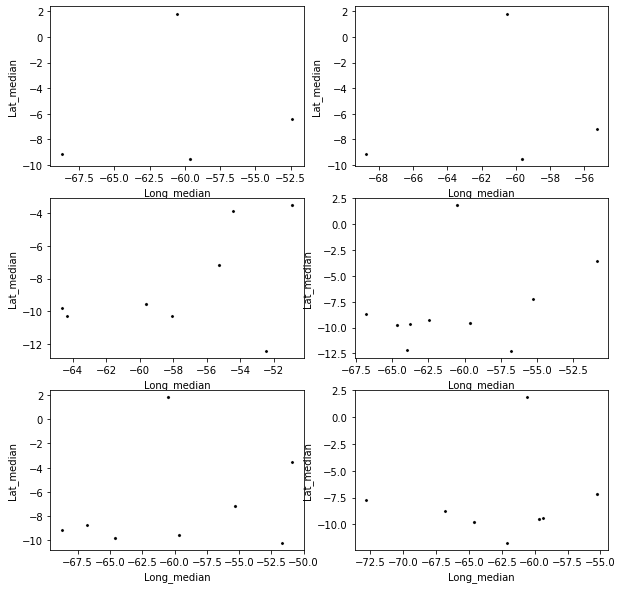

In [114]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10))
sns.scatterplot(
    data=tb_bimestre_desmata[(tb_bimestre_desmata['Bimestre'] == 1)&(tb_bimestre_desmata['Year'] >= 40)], x="Long_median", y="Lat_median", 
    ax = ax[0,0], color = 'black', s=10
)
sns.scatterplot(
    data=tb_bimestre_desmata[(tb_bimestre_desmata['Bimestre'] == 2)&(tb_bimestre_desmata['Year'] >= 40)], x="Long_median", y="Lat_median", 
    ax = ax[0,1], color = 'black', s=10
)
sns.scatterplot(
    data=tb_bimestre_desmata[(tb_bimestre_desmata['Bimestre'] == 3)&(tb_bimestre_desmata['Year'] >= 40)], x="Long_median", y="Lat_median", 
    ax = ax[1,0], color = 'black', s=10
)
sns.scatterplot(
    data=tb_bimestre_desmata[(tb_bimestre_desmata['Bimestre'] == 4)&(tb_bimestre_desmata['Year'] >= 40)], x="Long_median", y="Lat_median", 
    ax = ax[1,1], color = 'black', s=10
)
sns.scatterplot(
    data=tb_bimestre_desmata[(tb_bimestre_desmata['Bimestre'] == 5)&(tb_bimestre_desmata['Year'] >= 40)], x="Long_median", y="Lat_median", 
    ax = ax[2,0], color = 'black', s=10
)
sns.scatterplot(
    data=tb_bimestre_desmata[(tb_bimestre_desmata['Bimestre'] == 6)&(tb_bimestre_desmata['Year'] >= 40)], x="Long_median", y="Lat_median", 
    ax = ax[2,1], color = 'black', s=10
)